In [1]:
# base data sci libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from skimage.color import rgb2gray

# image processing libraries
import cv2
from PIL import Image
from scipy import ndimage

# sklearn for pipeline creation and grid-search cv
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

#

# BELOW ONLY NEEDED IF WE GO WITH THE IMPLEMENTATION OF A CNN, BUT I THINK THAT WOULD BE OVER THE TOP FOR THIS TASK
# ! pip install tensorflow
# import tensorflow as tf
# from tensorflow.keras import layers, models

np.random.seed(23)
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
sns.set()

### To-Dos
* Add feature functions into cell with extract_log_features() mimicking the format and the instructions there
* Decide on strategy in terms of flattening images or using scalar features -- what is worth spending computational umph on based on data exploration?
* Update parse_data() to include any features generated from the functions defined in the featurize block
* Add PCA and any other data exploration we want to complete for feature selection
* Once we have features, tweak and play with the grid-search CV to get some baseline results for our model

### FEATURIZE

We need to translate the features we have already created + those in the proposal + those in the dataset paper into features that are either scalars to be appended to the image vector or a vector of features that can be concatenated onto the end of the feature vector.

Below I have created a formula which defaults to producing a scalar representation of the Laplacian of Gaussian filter. You could also run the filter across the image and then flatten the resulting LoG filtered matrix into a vector (more computationally intensive). This function can be used as a template for the development of other feature formulae to be included in the df creation in the parse_data() function.

##### ERIN TO DO - remember how to use pandas pipeline so we can pass these functions as arguments into parse_data() instead of entering them manually


In [3]:
def extract_log_features(image_array, sigma=0.7, scalar=True):
    """
    Extract Laplacian of Gaussian (LoG) features from an image array.
    
    Parameters:
        image_array (numpy.ndarray): The input image array.
        sigma (float): The sigma value for the Gaussian filter. Controls the amount of smoothing.
        
    Returns:
        numpy.ndarray: The LoG filtered image as a feature vector.
    """
    # apply Laplacian of Gaussian filter
    log_image = ndimage.gaussian_laplace(image_array, sigma=sigma)

    if scalar:
        
        # OPTION 1
        
        # feature scalar: the sum of absolute values in the LoG image (a simple measure of edginess)
        feature_scalar = np.sum(np.abs(log_image))

        return feature_scalar

    else:
        # OPTION 2
        
        # feature vector: flatten the LoG image to use as a feature vector directly
        feature_vector = log_image.flatten()

        return feature_vector
    
### TO DO - ISI & ELLIS - Immitate the above formula to either create scalar features or feature vectors from those formulae we already explored ###

In [4]:
def extract_hog_features(image_array, orientation, pixels, scalar=True):
    """
    Extract HOG features from an image array.
    
    Parameters:
        image_array (numpy.ndarray): The input image array.
        saclar: if the output must be a scalar or a feature vector
        
    Returns:
        numpy.ndarray: The HOG as a feature vector or scalar.
    """
    #preprocessing
    # convert to floating point image with intensity [0, 1]
    if np.max(image_array) > 1:
        img = image_array.astype(np.float32) / 255.0
    # convert to grayscale
    if len(img.shape) > 2:
        img = rgb2gray(img)
    gray_img = img
    #HOG feature extraction
    #the orientation and pixels will increase the detail (more orientations and less pixels are more computationally expensive)
    feature_vector = hog(gray_img, orientations=orientation, pixels_per_cell=(pixels, pixels), visualize=False, feature_vector=True)  
    if scalar:
        feature_scalar = np.mean(feature_vector) #np.mean is for averaging features, np.sum is for the overall "strength" or "intensity" of the features.
        return feature_scalar
    else:
        return feature_vector


In [5]:
def extract_normals_features(image_array, scalar=True):
    #preprocessing
    # convert to floating point image with intensity [0, 1]
    if np.max(image_array) > 1:
        img = image_array.astype(np.float32) / 255.0
    # convert to grayscale
    if len(img.shape) > 2:
        img = rgb2gray(img)
    gray_img = img
    # Compute gradients using Sobel operator
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=3)

    # Compute normal vectors Nx, Ny, Nz
    norm = np.sqrt(sobel_x**2 + sobel_y**2 + 1e-6)
    nx = sobel_x / norm
    ny = sobel_y / norm
    nz = 1 / norm

    # Concatenate nx, ny, nz along a new axis, and flatten it to form a 1D feature vector
    feature_vector = np.stack((nx, ny, nz), axis=-1).reshape(-1)
    if scalar:
        feature_scalar = np.sum(feature_vector)
        return feature_scalar
    else:
        return feature_vector
    


In essence, each image needs to be represented as a feature vector. In the D200 example, the photos of the clothing items were in grayscale and then normalized and then reshaped using `train_images_vectors = np.reshape(train_images, (len(train_images), -1))` where train images is an array of n 28 x 28 training images (i.e. train_images.shape = (n, 28, 28)). After each image is reshaped, the vector is 1 x 784 (i.e. 28 x 28).

We need a dataframe at the end of the day, where each row represents an image and its features. I want to talk more about which features we are actually going to leverage and use as a team, but for right now, I will build the plumbing to be able to run a classification once we actually have the features using the 'full image' technique employed in D200. In our case the images are still 200 x 200.

### Parse Data to DF + Add In Features

In [2]:
def parse_data(folder_path):
    image_vectors = []  # image data
    labels = []  # labels
    ids = []  # unique IDs
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            parts = filename.split('_')
            fabType = parts[0]
            id1 = parts[1]
            id2 = parts[3].split('.')[0]  # Remove .png extension
            
            unique_id = id1 + id2

            img = Image.open(os.path.join(folder_path, filename)).convert('L')
            img_array = np.array(img)
            
            # normalize the image vector to be between 0 and 1
            img_vector_normalized = img_array.flatten() / 255.0
            
            image_vectors.append(img_vector_normalized)
            labels.append(fabType)
            ids.append(unique_id)

    X = np.array(image_vectors)
    Y = np.array(labels)
    unique_ids = np.array(ids)
    return X, Y, unique_ids

In [20]:
def parse_all(folder_path):
    image_vectors = []  # image data
    labels = []  # labels
    ids = []  # unique IDs
    features = []


    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            parts = filename.split('_')
            fabType = parts[0]
            id1 = parts[1]
            id2 = parts[3].split('.')[0]  # Remove .png extension
            
            unique_id = id1 + id2

            img = Image.open(os.path.join(folder_path, filename)).convert('L')
            img_array = np.array(img)
            
            # normalize the image vector to be between 0 and 1
            img_vector_normalized = img_array.flatten() / 255.0

            ### APPEND ANY OTHER SCALAR FEATURES ###
            scalar_features = []
            scalar_features.append(extract_log_features(img_array))
            scalar_features.append(extract_hog_features(img_array, 4, 20))
            scalar_features.append(extract_normals_features(img_array))

            

            scalar_features_array = np.array(scalar_features)
            # new_vector_with_scalar = np.append(img_vector_normalized, log_scalar)

            ### APPEND ANY OTHER VECTORIZED FEATURES ###
            log_vector = extract_log_features(img_array, scalar=False)
            hog_vector = extract_hog_features(img_array, 4, 20, scalar=False)
            normals_vector = extract_normals_features(img_array, scalar = False)
            
            
            #NOTE: This is created but then not used, I added as an additional output (features)
            final_img_feature_vector  = np.concatenate((img_vector_normalized, scalar_features_array, log_vector, hog_vector, normals_vector)) # BE SURE TO ADD ANY FEATURE VECTORS HERE
            
            image_vectors.append(img_vector_normalized)
            labels.append(fabType)
            ids.append(unique_id)
            features.append(final_img_feature_vector)

    X = np.array(image_vectors)
    Y = np.array(labels)
    unique_ids = np.array(ids)
    features_array = np.array(features)
    return X, Y, unique_id, features_array

Note - the cell below takes ~25 seconds to run on my mac. It may take a bit longer depending on your processing power and memory. If this becomes an issue, we can save the dataframe it creates as a pickle file, which could be saved to sub-samples and you two would be able to use without issue i.e. my computer processes and adds features and then saves it as a compressed python binary to allow for easy access that avoids double processing later. Just let me know if we need to do that!

Note 2 - After adding HOG and Normals features, it took 4 m 4.2 sec in my computer, the second time broke, so I created a code that is only to create the df. The original one + the 2 additional features is in parse_all

In [9]:
folder_path = './Subsamples/train'
X, Y, unique_ids = parse_all(folder_path)

df = pd.DataFrame(X)
df['category'] = pd.Categorical(Y)
df['label'], _ = pd.factorize(df['category'])
df['uid'] = unique_ids
df.head()

: 

: 

In [3]:
folder_path = './Subsamples/train'
X, Y, unique_ids = parse_data(folder_path)

df = pd.DataFrame(X)
df['category'] = pd.Categorical(Y)
df['label'], _ = pd.factorize(df['category'])
df['uid'] = unique_ids
df.head()

,0,1,2,3,4,5,6,7,8,9,...,39993,39994,39995,39996,39997,39998,39999,category,label,uid
0,0.062745,0.058824,0.066667,0.062745,0.062745,0.066667,0.082353,0.086275,0.101961,0.101961,...,0.066667,0.058824,0.054902,0.054902,0.058824,0.062745,0.062745,Blended,0,8821c
1,0.266667,0.258824,0.270588,0.301961,0.313725,0.352941,0.439216,0.478431,0.572549,0.607843,...,0.200000,0.333333,0.749020,0.803922,0.788235,0.760784,0.717647,Denim,1,1503c
2,0.235294,0.247059,0.274510,0.298039,0.309804,0.305882,0.282353,0.274510,0.270588,0.258824,...,0.168627,0.133333,0.125490,0.133333,0.160784,0.192157,0.211765,Polyester,2,16132c
3,0.380392,0.364706,0.356863,0.345098,0.341176,0.345098,0.388235,0.435294,0.450980,0.423529,...,0.400000,0.415686,0.450980,0.482353,0.482353,0.505882,0.545098,Blended,0,3621d
4,0.321569,0.317647,0.305882,0.298039,0.294118,0.301961,0.309804,0.313725,0.325490,0.333333,...,0.376471,0.298039,0.247059,0.278431,0.345098,0.333333,0.309804,Cotton,3,2333a


With this dataframe, which is in the same format as the data shown in the MNIST D200 homework, it should be easy to set up t-SNE and PCA. HOWEVER - at this point we don't have any true features, as our existing features need to be converted to columns in this dataframe. Below is skeleton code that can be filled out to run and add these features

### TO DO - INSERT PCA AND OTHER EDA

In [13]:
#reorder 
train_df = df
train_df.columns = train_df.columns.astype(str)
PIXEL_COLS = train_df.columns.tolist()[:-3] # list of pixel header
LABEL_COLS = ['label', 'category'] # list of labels header

cols_reorder = LABEL_COLS + PIXEL_COLS
train_df = train_df[cols_reorder]
train_df.head()

,label,category,0,1,2,3,4,5,6,7,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
0,0,Blended,0.062745,0.058824,0.066667,0.062745,0.062745,0.066667,0.082353,0.086275,...,0.086275,0.082353,0.070588,0.066667,0.058824,0.054902,0.054902,0.058824,0.062745,0.062745
1,1,Denim,0.266667,0.258824,0.270588,0.301961,0.313725,0.352941,0.439216,0.478431,...,0.164706,0.149020,0.176471,0.200000,0.333333,0.749020,0.803922,0.788235,0.760784,0.717647
2,2,Polyester,0.235294,0.247059,0.274510,0.298039,0.309804,0.305882,0.282353,0.274510,...,0.160784,0.180392,0.160784,0.168627,0.133333,0.125490,0.133333,0.160784,0.192157,0.211765
3,0,Blended,0.380392,0.364706,0.356863,0.345098,0.341176,0.345098,0.388235,0.435294,...,0.270588,0.270588,0.305882,0.400000,0.415686,0.450980,0.482353,0.482353,0.505882,0.545098
4,3,Cotton,0.321569,0.317647,0.305882,0.298039,0.294118,0.301961,0.309804,0.313725,...,0.576471,0.462745,0.411765,0.376471,0.298039,0.247059,0.278431,0.345098,0.333333,0.309804


In [14]:
#choose  a sample of the data to see if works:
# Sample data
sampled_train_df = train_df.sample(frac=0.2)


In [15]:
sampled_train_df

,label,category,0,1,2,3,4,5,6,7,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
2708,2,Polyester,0.054902,0.050980,0.054902,0.070588,0.078431,0.086275,0.094118,0.109804,...,0.164706,0.160784,0.156863,0.145098,0.141176,0.129412,0.109804,0.098039,0.082353,0.070588
18431,1,Denim,0.235294,0.262745,0.274510,0.270588,0.262745,0.262745,0.278431,0.250980,...,0.250980,0.239216,0.219608,0.188235,0.200000,0.250980,0.301961,0.301961,0.286275,0.258824
2311,3,Cotton,0.200000,0.203922,0.215686,0.227451,0.235294,0.247059,0.247059,0.250980,...,0.325490,0.298039,0.243137,0.223529,0.223529,0.337255,0.384314,0.396078,0.376471,0.352941
1377,0,Blended,0.313725,0.305882,0.301961,0.305882,0.337255,0.364706,0.443137,0.447059,...,0.352941,0.352941,0.360784,0.364706,0.368627,0.368627,0.364706,0.364706,0.356863,0.341176
336,1,Denim,0.078431,0.094118,0.082353,0.050980,0.047059,0.047059,0.047059,0.050980,...,0.078431,0.070588,0.058824,0.054902,0.054902,0.058824,0.074510,0.121569,0.196078,0.239216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18067,3,Cotton,0.223529,0.215686,0.211765,0.231373,0.262745,0.325490,0.384314,0.388235,...,0.717647,0.729412,0.733333,0.733333,0.749020,0.756863,0.764706,0.796078,0.831373,0.843137
3842,0,Blended,0.156863,0.160784,0.160784,0.168627,0.168627,0.168627,0.192157,0.243137,...,0.145098,0.145098,0.172549,0.192157,0.192157,0.203922,0.192157,0.184314,0.160784,0.141176
2222,3,Cotton,0.713725,0.701961,0.701961,0.694118,0.698039,0.709804,0.721569,0.741176,...,0.709804,0.709804,0.717647,0.725490,0.737255,0.749020,0.752941,0.756863,0.772549,0.800000
10331,2,Polyester,0.301961,0.298039,0.266667,0.235294,0.223529,0.192157,0.176471,0.176471,...,0.278431,0.341176,0.415686,0.439216,0.396078,0.356863,0.349020,0.337255,0.325490,0.313725


In [16]:
#PCA (From data 200 code, lecture-26) - This is too heavy to run
n_comps = 50
PCA_COLS = [f"pc{i+1}" for i in range(n_comps)]
pca = PCA(n_components=n_comps)
pca.fit(sampled_train_df[PIXEL_COLS])
principal_components = pca.transform(sampled_train_df[PIXEL_COLS])

In [17]:
np.sum(pca.explained_variance_ratio_)

0.8897120776964395

In [18]:
# PC1, PC2 component scores
np.sum(pca.explained_variance_ratio_[:2])

0.8465544761266028

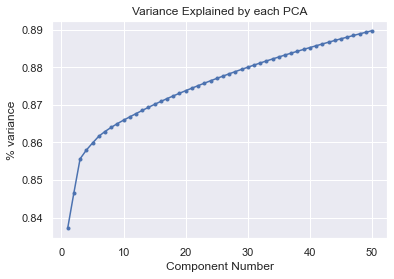

In [38]:
variances = pca.explained_variance_ratio_

cumulatives = [] 

for i in range(len(variances)):
    if i == 0:
        cumulative = variances[i]  # For the first element, cumulative sum is the variance itself
    else:
        cumulative += variances[i]  # Accumulate the current variance to the previous cumulative sum
    cumulatives.append(cumulative)

cumulatives
# plot the explained variance (here we have to do it in the opposite side)
plt.plot(np.arange(n_comps)+1,
         cumulatives,
         marker='.');
plt.ylabel("% variance")
plt.xlabel("Component Number")
plt.title("Variance Explained by each PCA")
plt.show()

### SVM - Multi-Class Classifier


The function below takes in a test DF, features (which we can modified in the event we have thousands of columns and they are named numerically -- in this case we just need to drop the target variable to define X). It runs cross validation to determine the best hyperparameters to be used for the support vector machine model, returning a grid search object with the following attributes (per ChatGPT):

<b>Attributes</b>
* best_estimator_: The estimator that was chosen by the search, i.e., the estimator which gave highest score (or smallest loss if specified) on the left out data. Not available if refit=False.
* best_score_: The score of the best_estimator on the left out data.
* best_params_: The parameter setting that gave the best results on the hold out data.
* best_index_: The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.
* cv_results_: A dictionary with keys as column headers and values as columns, that can be imported into a pandas DataFrame. This attribute provides scores, fit times, score times, and parameters for all the candidate models. It contains a lot of detailed information for each parameter combination that was evaluated.
* scorer_: The function or a dictionary of functions that scores the predictions on the test set.
* n_splits_: The number of cross-validation splits (folds/iterations).
* refit_time_: Time for refitting the best estimator on the whole dataset (available only if refit is set to True).

<b>Methods</b>
* fit(X, y=None, groups=None): Run fit with all sets of parameters.
* predict(X): Call predict on the estimator with the best found parameters.
* score(X, y=None): Returns the score on the given data, if the estimator has been refit.
* predict_proba(X): Call predict_proba on the estimator with the best found parameters, if available.
* decision_function(X): Call decision_function on the estimator with the best found parameters, if available.
* transform(X): Call transform on the estimator with the best found parameters, if available.
* inverse_transform(X): Call inverse_transform on the estimator with the best found parameters, if available.

In [26]:
def svm_grid_search_cv(dataframe, features, target, cv_folds=5):
    """
    Perform grid search cross-validation for SVM classifier on the given dataframe.
    
    Parameters:
    - dataframe: The pandas DataFrame containing the dataset.
    - features: List of column names to be used as features.
    - target: The name of the column to be used as the target variable.
    - cv_folds: Number of folds for cross-validation.
    
    Returns:
    - grid_search: The fitted GridSearchCV object.
    """
    
    # Separate the features and the target variable
    X = dataframe[features]
    y = dataframe[target]
    
    # Split the data into training and testing sets (optional, could also perform CV on the entire dataset)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define a pipeline that includes scaling and the classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling is important for SVM
        ('svm', SVC(probability=True))  # SVM classifier
    ])
    
    # Parameter grid for GridSearchCV
    param_grid = {
        'svm__C': [0.1, 1, 10],  # SVM regularization parameter
        'svm__kernel': ['linear', 'rbf'],  # Kernel type to be used in the algorithm
        'svm__gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv_folds, scoring='accuracy', verbose=1)
    
    # Perform grid search cross-validation
    grid_search.fit(X_train, y_train)
    
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
    
    # Optionally, evaluate on the test set
    test_score = grid_search.score(X_test, y_test)
    print("Test set score: {:.2f}".format(test_score))
    
    return grid_search


### Convolutional Neural Network

The below code has not been tested or debugged - it was read through against a TDS article for accuracy, but it would need significant work, change in approach (and potentially additional compute) if we are to make it work. I wanted to store it so I don't lose the information though!

In [ ]:
# simple cnn model
# def create_cnn_model(input_shape, num_classes):
#     model = models.Sequential([
#         # convolutional layer with ReLU activation and Max Pooling
#         layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
#         layers.MaxPooling2D((2, 2)),
        
#         # convolutional layer 2
#         layers.Conv2D(64, (3, 3), activation='relu'),
#         layers.MaxPooling2D((2, 2)),
        
#         # flatten the output and add dense layers for classification
#         layers.Flatten(),
#         layers.Dense(64, activation='relu'),
#         layers.Dense(num_classes, activation='softmax')
#     ])
    
#     return model

# input_shape = (64, 64, 3)  # input shape (height, width, channels)
# num_classes = 5

# model = create_cnn_model(input_shape, num_classes)

# # compile the model
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])


# # train_images, train_labels = ... 
# # val_images, val_labels = ... 

# train model
# history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))


In [ ]:
## TO DO - ADD SVM CODE